In [4]:
import pandas as pd

This file aims to draft the replication of Commodities return following the KMPV methods.

In [2]:
raw_data = pd.read_parquet("../../_data/futures_returns/commodity_futures.parquet")

In [5]:
raw_data.head()

,index,KW1 Comdty_PX_LAST,KW2 Comdty_PX_LAST,KW3 Comdty_PX_LAST,SI3 Comdty_PX_LAST
0,1970-01-05,137.375,135.500,131.750,NaN
1,1970-01-06,138.250,136.750,132.625,NaN
2,1970-01-07,139.125,136.750,132.875,NaN
3,1970-01-08,139.500,137.250,133.125,NaN
4,1970-01-09,139.000,136.375,132.875,NaN


KW -- Kansa Wheat  (Wheat in Yang's Paper)
SI -- Silver

In [31]:
import pandas as pd
import numpy as np

df = raw_data.copy()

print(df.columns)

df["Date"] = pd.to_datetime(df["index"])
df = df.set_index("Date")

df_monthly = df.resample("M").last()


def compute_monthly_carry(df):
    maturities = np.array([1, 2, 3])

    price_cols = ["KW1 Comdty_PX_LAST", "KW2 Comdty_PX_LAST", "KW3 Comdty_PX_LAST"]
    spot_list = []
    fut1m_list = []
    carry_list = []

    for _, row in df[price_cols].iterrows():
        prices = row.values.astype(float)
        coefs = np.polyfit(maturities, prices, 2)

        spot = np.polyval(coefs, 0)
        fut1m = np.polyval(coefs, 1)
        carry = (spot - fut1m) / fut1m

        spot_list.append(spot)
        fut1m_list.append(fut1m)
        carry_list.append(carry)

    df_carry = df.copy()
    df_carry["Spot_Price"] = spot_list
    df_carry["Futures_1M"] = fut1m_list
    df_carry["Carry"] = carry_list

    return df_carry


df_carry = compute_monthly_carry(df_monthly)


df_carry["Simple_Return"] = df_carry["KW1 Comdty_PX_LAST"].pct_change()

# Roll return
roll_prices = []
kw1 = df_carry["KW1 Comdty_PX_LAST"]
kw2 = df_carry["KW2 Comdty_PX_LAST"]
kw3 = df_carry["KW3 Comdty_PX_LAST"]

for i in range(len(df_carry)):
    if i % 3 == 0:
        roll_prices.append(kw1.iloc[i])
    elif i % 3 == 1:
        roll_prices.append(kw2.iloc[i])
    else:
        roll_prices.append(kw3.iloc[i])

df_carry["Roll_Price"] = roll_prices
df_carry["Roll_Return"] = df_carry["Roll_Price"].pct_change()

print(df_carry[["Carry", "Simple_Return", "Roll_Return"]])

Index(['index', 'KW1 Comdty_PX_LAST', 'KW2 Comdty_PX_LAST',
       'KW3 Comdty_PX_LAST', 'SI3 Comdty_PX_LAST'],
      dtype='object')


C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_30236\1751298246.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').last()


               Carry  Simple_Return  Roll_Return
Date                                            
1970-01-31  0.032374            NaN          NaN
1970-02-28  0.001787       0.006295    -0.008993
1970-03-31  0.098732      -0.013405    -0.019056
1970-04-30  0.097670       0.010870     0.032377
1970-05-31 -0.007729      -0.072581    -0.057348
...              ...            ...          ...
2025-02-28 -0.029557      -0.036254    -0.010790
2025-03-31 -0.019749      -0.002239     0.020942
2025-04-30 -0.030627      -0.076750    -0.120940
2025-05-31 -0.010783       0.036947     0.063685
2025-06-30 -0.009910       0.040788     0.085466

[666 rows x 3 columns]


In [39]:
df_carry["Month"] = df_carry.index.to_period("M").to_timestamp()

In [41]:
df_carry = df_carry.drop(columns="index")

In [42]:
import sys
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Plotting style
sns.set()

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Load project modules
from he_kelly_manela import pull_he_kelly_manela

# Load project settings
from settings import config

DATA_DIR = Path(config("DATA_DIR")) / "cds_returns"
HE_DATA_DIR = Path(config("DATA_DIR")) / "he_kelly_manela"

from he_kelly_manela import pull_he_kelly_manela

he_kelly = pull_he_kelly_manela.load_he_kelly_manela_all(data_dir=HE_DATA_DIR)

he_kelly.columns.str.contains("cmd").sum()


col_lst = ["yyyymm"]
for i in range(1, 10):
    col_lst.append(f"Commod_0{i}")
for i in range(10, 24):
    col_lst.append(f"Commod_{i}")

# %%
he_kelly_df = he_kelly[col_lst].dropna(axis=0)
he_kelly_df["Month"] = pd.to_datetime(
    he_kelly_df["yyyymm"].astype(int).astype(str), format="%Y%m"
)
he_kelly_df = he_kelly_df.drop(columns="yyyymm")
he_kelly_df = he_kelly_df.set_index("Month")

In [43]:
he_kelly_df

,Commod_01,Commod_02,Commod_03,Commod_04,Commod_05,Commod_06,Commod_07,Commod_08,Commod_09,Commod_10,...,Commod_14,Commod_15,Commod_16,Commod_17,Commod_18,Commod_19,Commod_20,Commod_21,Commod_22,Commod_23
Month,,,,,,,,,,,,,,,,,,,,,
1986-09-01,0.0718,-0.0525,-0.0753,0.2569,-0.0442,0.0935,0.0500,-0.0686,0.0426,-0.0103,...,0.0287,-0.0206,-0.1254,-0.0626,-0.0199,0.0179,0.0778,-0.0012,0.0197,0.0953
1986-10-01,-0.0154,-0.0649,0.0384,0.0081,0.0052,-0.0540,-0.0352,-0.0280,0.1162,-0.1431,...,0.0646,-0.1080,-0.0112,0.0182,0.0319,0.0223,0.0145,0.0007,0.0834,-0.0378
1986-11-01,-0.0204,-0.0146,-0.0185,0.1276,0.0290,-0.0316,0.0312,-0.0052,0.0358,-0.1337,...,0.1823,-0.1230,-0.1793,-0.0171,-0.0123,0.0104,-0.0480,-0.0147,0.0376,0.0008
1986-12-01,-0.1003,0.0305,0.1528,0.1197,-0.0382,0.0353,0.0052,0.1545,0.0014,-0.0926,...,0.0551,-0.0175,-0.0084,0.1719,-0.0605,-0.0204,0.0021,-0.0293,-0.0370,-0.0428
1987-01-01,-0.0189,-0.0531,0.0420,-0.0753,0.1211,0.0003,-0.0078,0.0488,-0.0272,-0.0867,...,-0.0099,0.0585,0.1069,0.0279,0.0214,0.0102,0.0162,-0.0158,0.0484,-0.0104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-01,-0.0057,0.1002,0.0883,0.0801,0.0291,0.0444,0.0095,0.1050,0.1311,-0.0655,...,0.0297,0.0611,0.0817,0.1266,-0.0392,0.0656,0.1165,0.0673,-0.0175,0.0100
2012-09-01,-0.0558,-0.0366,-0.0479,-0.0950,-0.0196,0.0499,0.0847,-0.0085,-0.0490,0.0518,...,-0.0702,0.0181,0.0800,0.0228,0.0123,-0.0905,0.0951,-0.0907,0.0146,-0.0639
2012-10-01,-0.0006,-0.0521,-0.0616,-0.0081,0.0113,-0.0313,-0.0653,-0.0255,-0.0627,-0.1149,...,0.0488,-0.0498,-0.0558,-0.0519,-0.0422,-0.0342,-0.0675,-0.0138,-0.0429,0.0288


In [27]:
df_carry = df_carry.drop(columns="index")

In [45]:
df_carry

,KW1 Comdty_PX_LAST,KW2 Comdty_PX_LAST,KW3 Comdty_PX_LAST,SI3 Comdty_PX_LAST,Spot_Price,Futures_1M,Carry,Simple_Return,Roll_Price,Roll_Return,Month
Date,,,,,,,,,,,
1970-01-31,139.000,135.25,132.250,NaN,143.500,139.000,0.032374,NaN,139.000,NaN,1970-01-01
1970-02-28,139.875,137.75,133.750,NaN,140.125,139.875,0.001787,0.006295,137.750,-0.008993,1970-02-01
1970-03-31,138.000,132.50,135.125,NaN,151.625,138.000,0.098732,-0.013405,135.125,-0.019056,1970-03-01
1970-04-30,139.500,134.00,136.625,NaN,153.125,139.500,0.097670,0.010870,139.500,0.032377,1970-04-01
1970-05-31,129.375,131.50,134.750,NaN,128.375,129.375,-0.007729,-0.072581,131.500,-0.057348,1970-05-01
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,558.250,573.00,586.000,31.803,541.750,558.250,-0.029557,-0.036254,573.000,-0.010790,2025-02-01
2025-03-31,557.000,570.00,585.000,35.219,546.000,557.000,-0.019749,-0.002239,585.000,0.020942,2025-03-01
2025-04-30,514.250,529.50,544.250,33.124,498.500,514.250,-0.030627,-0.076750,514.250,-0.120940,2025-04-01


In [47]:
df_carry = df_carry.set_index("Month", drop=True)

In [48]:
df_carry

,KW1 Comdty_PX_LAST,KW2 Comdty_PX_LAST,KW3 Comdty_PX_LAST,SI3 Comdty_PX_LAST,Spot_Price,Futures_1M,Carry,Simple_Return,Roll_Price,Roll_Return
Month,,,,,,,,,,
1970-01-01,139.000,135.25,132.250,NaN,143.500,139.000,0.032374,NaN,139.000,NaN
1970-02-01,139.875,137.75,133.750,NaN,140.125,139.875,0.001787,0.006295,137.750,-0.008993
1970-03-01,138.000,132.50,135.125,NaN,151.625,138.000,0.098732,-0.013405,135.125,-0.019056
1970-04-01,139.500,134.00,136.625,NaN,153.125,139.500,0.097670,0.010870,139.500,0.032377
1970-05-01,129.375,131.50,134.750,NaN,128.375,129.375,-0.007729,-0.072581,131.500,-0.057348
...,...,...,...,...,...,...,...,...,...,...
2025-02-01,558.250,573.00,586.000,31.803,541.750,558.250,-0.029557,-0.036254,573.000,-0.010790
2025-03-01,557.000,570.00,585.000,35.219,546.000,557.000,-0.019749,-0.002239,585.000,0.020942
2025-04-01,514.250,529.50,544.250,33.124,498.500,514.250,-0.030627,-0.076750,514.250,-0.120940


In [49]:
common_idx = he_kelly_df.index.intersection(df_carry.index)

he_kelly_sub = he_kelly_df.loc[common_idx]
carry_sub = df_carry.loc[common_idx]

In [52]:
corr_matrix = pd.DataFrame(index=carry_sub.columns, columns=he_kelly_df.columns)


for col1 in carry_sub.columns:
    for col2 in he_kelly_df.columns:
        x = carry_sub[col1].fillna(0)
        y = he_kelly_df[col2].fillna(0)
        corr_matrix.loc[col1, col2] = x.corr(y)

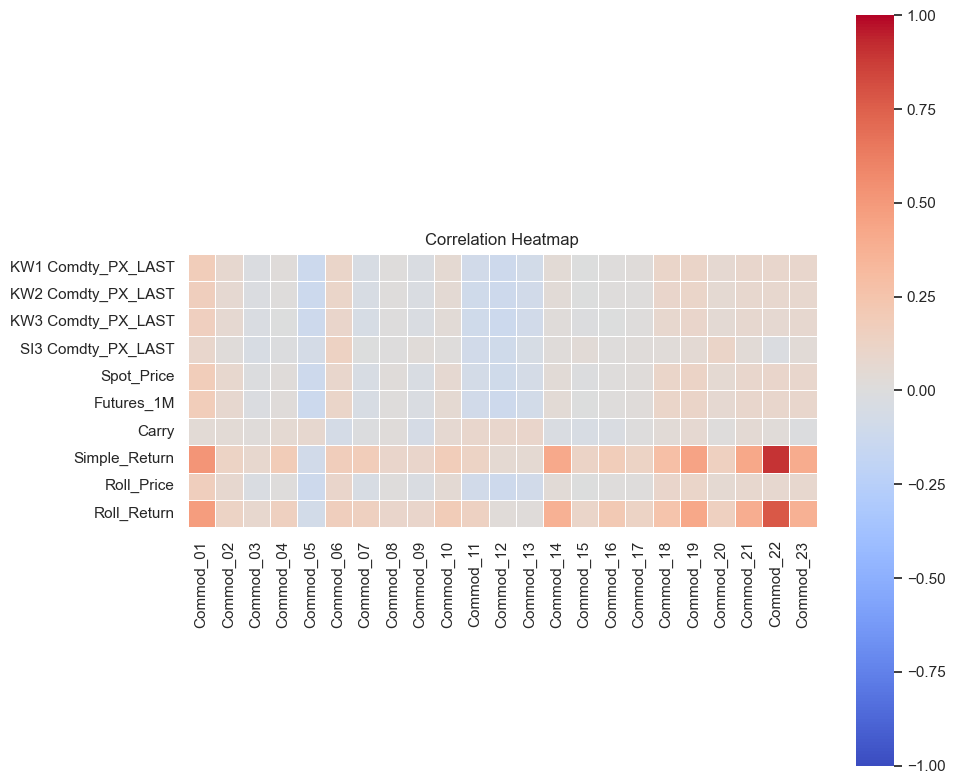

In [53]:
corr_matrix_float = corr_matrix.astype(float)
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix_float,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

I only have four columns of data — the first, second, and third nearby futures prices plus the date. I followed the KMPW method to calculate carry, using their approach of fitting the futures curve to get the spot price and a constant one-month-ahead futures price.

For returns, the paper actually just uses the GSCI index and doesn’t compute returns from the futures prices directly. But since I don’t have the GSCI return series, I tried two simple ways to approximate it:

Simple return, which is just the month-over-month price change of the front-month contract (KW1). This isn’t how the paper does it but feels like a reasonable shortcut.

A naive rolling return, where I just cycle through KW1 → KW2 → KW3 → KW1 by month. This is obviously not how GSCI’s actual roll works — GSCI rolls gradually over a few days each month — but it gives me a rough idea of how rolling might affect returns.

Surprisingly, even the simple front-month return has a pretty high correlation with one of the commodities in the He, Kelly, Manela paper. So while it’s not a perfect replication (especially since I didn’t model the actual roll mechanics), it seems like the front-month price captures a good chunk of the return variation that GSCI represents in their data.